In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [8]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Preprocessiong
* * * *


 mu = 15.50 and sigma = 7.75



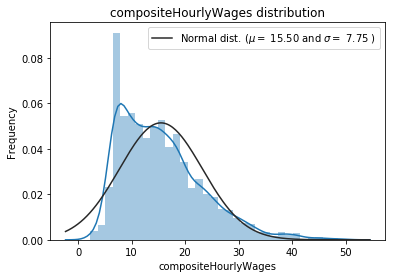

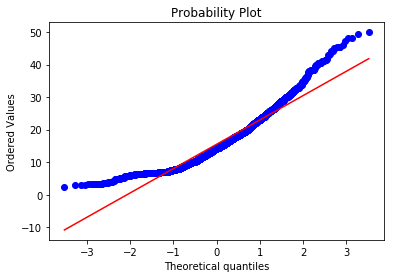

In [58]:
# ヒストグラムとカーネル密度推定による確率密度関数
# fitを使えば分布のフィッティングもできる
sns.distplot(train['compositeHourlyWages'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['compositeHourlyWages'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('compositeHourlyWages distribution')

#Get also the QQ-plot
# > X軸上に観測した累積パーセント、Y軸上に期待累積パーセントを持つグラフ
# > ヒストグラムよりなじみは薄いと思うので、わからなければ 一直線上になっていれば正規分布であるくらいに覚えておけばOK
fig = plt.figure()
res = stats.probplot(train['compositeHourlyWages'], plot=plt)
plt.show()


 mu = 2.70 and sigma = 0.46



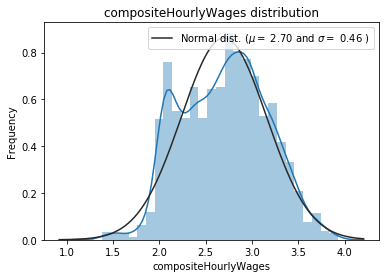

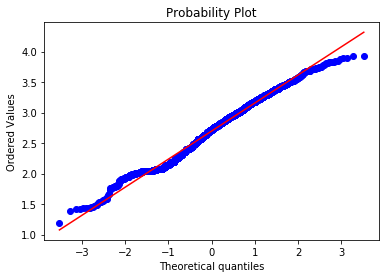

In [59]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["compositeHourlyWages"] = np.log1p(train["compositeHourlyWages"])

#Check the new distribution 
sns.distplot(train['compositeHourlyWages'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['compositeHourlyWages'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('compositeHourlyWages distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['compositeHourlyWages'], plot=plt)
plt.show()

* * *

In [9]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

## XGBoost

### 1. Validation with local train

In [11]:
# xgboostモデルの作成
#ind_params = {'objective': 'reg:linear'}

#reg = xgb.XGBRegressor(**ind_params)
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [13]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  6.02475299555
MSE from local train:  36.2976486573
R2 from local train:  0.395235324935


### 2. Validation with GridSearch

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.1],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.8,0.85,0.9,0.95],
    'colsample_bytree' : [0.5,1.0],
    'min_child_weight' : [5,10,15]
}

In [16]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'min_child_weight': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [17]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 100, 'objective': 'reg:gamma', 'subsample': 0.8}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
MSE:  -38.8108460369


In [18]:
# The result of combination
index = 1
for params, mean_score, scores in grid.grid_scores_:
    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
    print("Params: %r" % params)
    print("_"*30)
    index = index + 1

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


1) -182.547 (+/-4.804) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.8}
______________________________
2) -182.552 (+/-4.804) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.85}
______________________________
3) -182.551 (+/-4.804) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.9}
______________________________
4) -182.560 (+/-4.805) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.95}
______________________________
5) -45.105 (+/-1.839) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50,

In [19]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_) # 6.01679534923
#gdm = xgb.XGBRegressor(**xgb_params) # 6.0907929398
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [20]:
y_pred_gs = gdm.predict(X_test)

In [21]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

RMSE from local train:  5.99341470614
MSE from local train:  35.9210198398
R2 from local train:  0.401510436764


In [43]:
predictions_gdm = gdm.predict(test)

__Findings__
- RMSEがやや下がっている。
- R2がやや増えている。過学習までには至っていないと判断。

## Lasso

In [22]:
from sklearn.linear_model import Lasso

In [33]:
lasso = Lasso().fit(X_train, y_train)

In [37]:
y_pred_la = lasso.predict(X_test)

In [38]:
print("RMSE from local train: ", rmse(y_test, y_pred_la))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_la))
print("R2 from local train: ", r2_score(y_test, y_pred_la))

RMSE from local train:  6.44155333605
MSE from local train:  41.4936093812
R2 from local train:  0.308664056133


In [39]:
from sklearn import linear_model, datasets
lassocv = linear_model.LassoCV()
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [40]:
# The estimator chose automatically its lambda:
lassocv.alpha_ 

0.032483911319376148

In [42]:
best_alpha = 0.032483911319376148

mod_las = Lasso(alpha=best_alpha, max_iter=50000)
mod_las.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = mod_las.predict(X_test)

print("Lasso score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
predictions_las = mod_las.predict(test)

Lasso score on training set:  6.2777937513


# Submission

In [44]:
predictions = (predictions_gdm + predictions_las) / 2

In [45]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions
sub.to_csv('rs_hourly_submission_27-Dec-2017.csv',index=False)